In [837]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import os,sys, gc
import matplotlib.pyplot as plt
from scipy.stats import entropy
sys.path.append("/content/drive/My Drive/phd/")
sys.path.append("/content/drive/My Drive/phd/master_thesis/hsbm/")
from hsbmpy import get_max_available_L

In [0]:
#label = 'disease_type'
algorithm = "topsbm"
directory='/content/drive/My Drive/phd/datasets/merged'
L = get_max_available_L(directory, algorithm)-2
os.chdir(directory)

In [1006]:
label = 'status'

df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,L)).set_index('doc').drop('i_doc', axis=1)
df_words = pd.read_csv("%s/%s_level_%d_word-dist.csv"%(algorithm,algorithm,L), index_col=0)
df_words.index=[g[:15] for g in df_words.index]
df = pd.read_csv("mainTable.csv", index_col=0).reindex(index=df_words.index)
df = df.divide(df.sum(0),1).transpose().fillna(0)
df_files=pd.read_csv("files.dat", index_col=0)
df_topics.insert(0,'tissue', df_files.reindex(index=df_topics.index)[label])
df_topic_tissue = df_topics.groupby('tissue').mean()
df_files.head()

,primary_site,status,dataset,tissue_hd
TCGA-E8-A2JQ-11A-11R-A180-07,Thyroid,healthy,tcga,Thyroid_healthy
TCGA-EL-A3ZK-11A-11R-A23N-07,Thyroid,healthy,tcga,Thyroid_healthy
TCGA-BJ-A28X-11A-11R-A22L-07,Thyroid,healthy,tcga,Thyroid_healthy
TCGA-BJ-A28R-11A-11R-A16R-07,Thyroid,healthy,tcga,Thyroid_healthy
TCGA-EL-A3T8-11A-11R-A22L-07,Thyroid,healthy,tcga,Thyroid_healthy


## Projection based predictions

In [1007]:
df_Pst = pd.DataFrame(data=pd.np.matmul(df.values,df_words.values), index= df.index, columns=df_words.columns)
df_Pst = df_Pst.subtract(df_Pst.mean(1), 0)
predictions = pd.np.array(list(map(lambda x: list(map(lambda y: entropy(x, y), df_topic_tissue.astype(float).values)), df_Pst.astype(float).values)))

df_Pst.insert(0,'tissue', df_files.reindex(index=df_Pst.index)[label])
reals = pd.np.unique(df_Pst.tissue, return_inverse=True)[1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: divide by zero encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [1009]:
accuracy_score(reals, pd.np.argmin(predictions, axis=1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.


0.56375

## NN based predictor

In [1010]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Convolution1D
from tensorflow.keras.losses import binary_crossentropy,mean_squared_error, categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.framework.graph_util import convert_variables_to_constants
from tensorflow.python.client.device_lib import list_local_devices
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import os,sys, gc
list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3037493884687044784, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17656839530653197932
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13093161752487801284
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701093952
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9325162890197945508
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [1011]:
df_labels=df_files.copy()
df_labels=df_labels.reindex(index=df_topics.index)

uniq = len(df_labels[label].unique())

X_train = df_topics.drop('tissue',1)
X_train = X_train.subtract(X_train.mean(0),1).divide(0.5*(X_train.max(0)-X_train.min(0)),1).values.astype(float) #SGD transform
Y_train = to_categorical(np.unique(df_labels[label], return_inverse=True)[1])
inputs = X_train.shape[1]

if uniq==2:
  Y_train = np.abs((np.argmax(Y_train, axis=-1)-1)) #1="healthy"
  uniq = 1
  activation_func = "sigmoid"
  lr = 0.01
  momentum = 0.9
  l1 = 0.01
  l2 = 0.0001
  loss=binary_crossentropy
else:
  activation_func = "softmax"
  lr = 0.003
  momentum = 0.95
  l1 = 0.001
  l2 = 0
  loss=categorical_crossentropy


classes=np.unique(df_labels[df_labels.index.isin(df.index)][label], return_inverse=True)[0]

X_tm_train, X_tm_test, Y_tm_train, Y_tm_test = train_test_split(X_train, Y_train, random_state=42, train_size=0.95)

print(X_train.shape, Y_train.shape, X_tm_train.shape, Y_tm_train.shape)

(800, 1941) (800,) (760, 1941) (760,)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               194200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 194,301
Trainable params: 194,301
Non-trainable params: 0
_________________________________________________________________
None


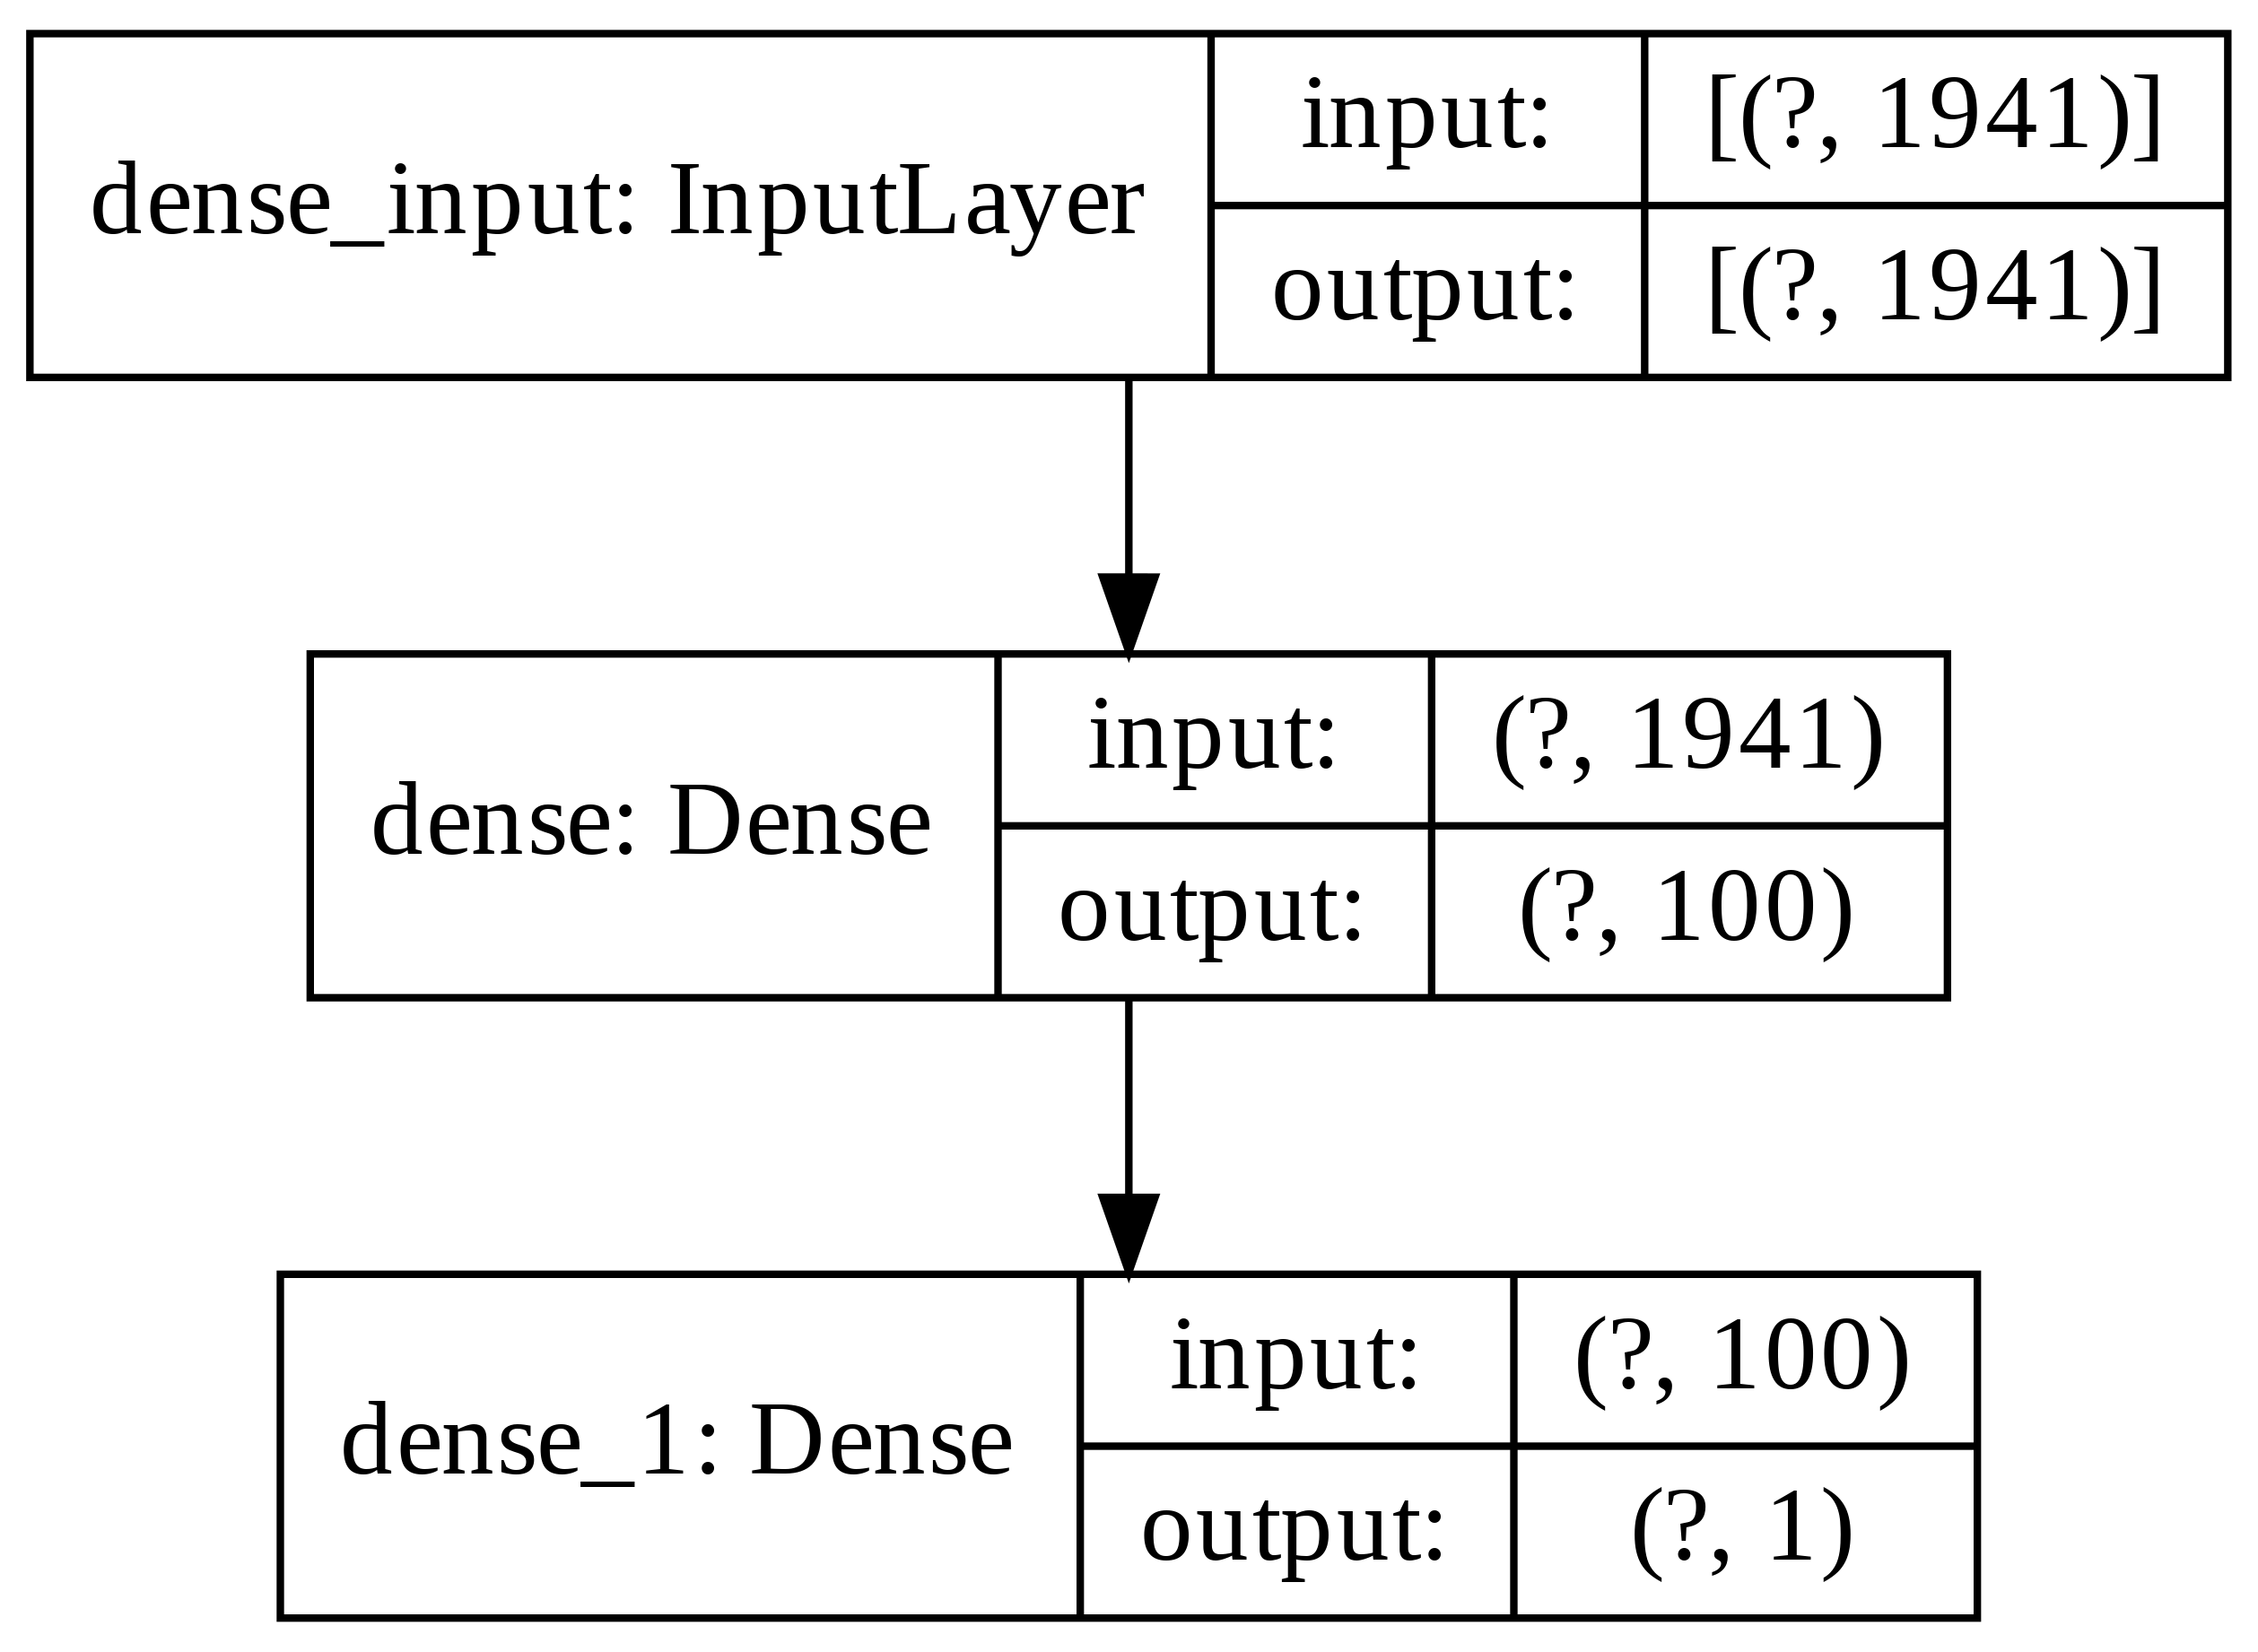

In [1012]:
K.clear_session()

os.system("rm -rf log.csv")
csv_logger = CSVLogger('log.csv', append=True, separator=',')
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, mode='min', patience=25)

model=Sequential()
model.add(Dense(units=100, input_dim=inputs, use_bias=True, bias_initializer="ones", activation="relu", kernel_regularizer=l1_l2(l1=0.01, l2=0.0001)))
model.add(Dense(units=uniq, activation=activation_func))
model.compile(loss=loss, optimizer=SGD(lr=lr, momentum=momentum), metrics=['accuracy', 'AUC'])
K.set_learning_phase(0)

print(model.summary())
plot_model(model, to_file=f"model_{label}.png", dpi=600, show_shapes=True)


In [1013]:
with tf.device("GPU"):
    model.fit(X_tm_train, Y_tm_train, epochs=1000, batch_size=500, verbose=1, validation_split=0.25, callbacks=[csv_logger, es], shuffle=True, use_multiprocessing=True, workers=-1)

Epoch 1/1000
2/2 [==============================] - 0s 173ms/step - loss: 53.2946 - accuracy: 0.5737 - auc: 0.6237 - val_loss: 52.8168 - val_accuracy: 0.6263 - val_auc: 0.6441
Epoch 2/1000
2/2 [==============================] - 0s 25ms/step - loss: 52.5477 - accuracy: 0.6351 - auc: 0.6770 - val_loss: 51.6071 - val_accuracy: 0.6632 - val_auc: 0.7499
Epoch 3/1000
2/2 [==============================] - 0s 24ms/step - loss: 51.2055 - accuracy: 0.6544 - auc: 0.7628 - val_loss: 49.9242 - val_accuracy: 0.7158 - val_auc: 0.8426
Epoch 4/1000
2/2 [==============================] - 0s 25ms/step - loss: 49.4486 - accuracy: 0.6982 - auc: 0.8413 - val_loss: 47.8908 - val_accuracy: 0.8000 - val_auc: 0.8994
Epoch 5/1000
2/2 [==============================] - 0s 31ms/step - loss: 47.3487 - accuracy: 0.8088 - auc: 0.8894 - val_loss: 45.6126 - val_accuracy: 0.8632 - val_auc: 0.9302
Epoch 6/1000
2/2 [==============================] - 0s 29ms/step - loss: 44.9976 - accuracy: 0.8544 - auc: 0.9200 - val_loss

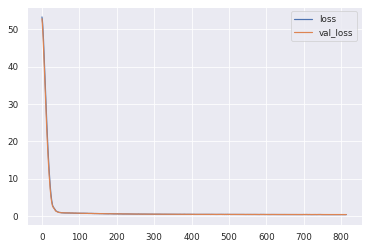

In [1014]:
pd.read_csv("log.csv", sep=",")[['loss','val_loss']].plot()

In [1015]:
model.evaluate(X_tm_test, Y_tm_test)

2/2 [==============================] - 0s 4ms/step - loss: 0.4427 - accuracy: 0.9750 - auc: 1.0000


[0.44266098737716675, 0.9750000238418579, 1.0]

In [0]:
model.save(f"model_{label}.h5")
#model = load_model("model.h5")

In [849]:
gc.collect()

732

# evaluate on non used on topsbm training


In [0]:
df_test_table = pd.read_csv("mainTable_test.csv", index_col = 0)
df_test_table = df_test_table.where(df_test_table<1e5,1e5)

In [0]:
#get only HV genes
df_test = df_test_table.reindex(index=df_words.index)
df_test = df_test.transpose().fillna(-1).astype(int)

df_test = pd.DataFrame(data=np.matmul(df_test.values,df_words.values), index=df_test.index, columns=df_words.columns)
df_test=df_test.divide(df_test.mean(axis=0), axis=1) #normalize P(t|d)

df_test = df_test.subtract(df_topics.drop("tissue",1).mean(0),1).divide((X_train.max(0)-X_train.min(0)),1) #SGD transform

In [0]:
classes = np.unique(df_files.reindex(index=df_test.index)[label])
X_test = df_test.values.astype(float)
Y_test = to_categorical([np.where(classes==t)[0][0] for t in df_files.reindex(index=df_test.index)[label].values.ravel()])
if uniq==1:
  Y_test = np.abs(np.argmax(Y_test, axis=-1)-1)
  uniq=1

In [1020]:
model.evaluate(X_test, Y_test, verbose=2, workers=-1, use_multiprocessing=True)

161/161 - 1s - loss: 0.6991 - accuracy: 0.9378 - auc: 0.9803


[0.6990926861763, 0.9378288984298706, 0.9803199172019958]

In [0]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

In [0]:
y_pred_p = model.predict(X_test)
if uniq>1:
  y_true = np.argmax(Y_test,axis=-1)
  y_pred = np.argmax(y_pred_p,axis=-1)
else:
  y_true = Y_test
  y_pred = np.ones(y_pred_p.shape)
  y_pred[y_pred_p<0.8]=0
results = confusion_matrix(y_true, y_pred, normalize="true")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


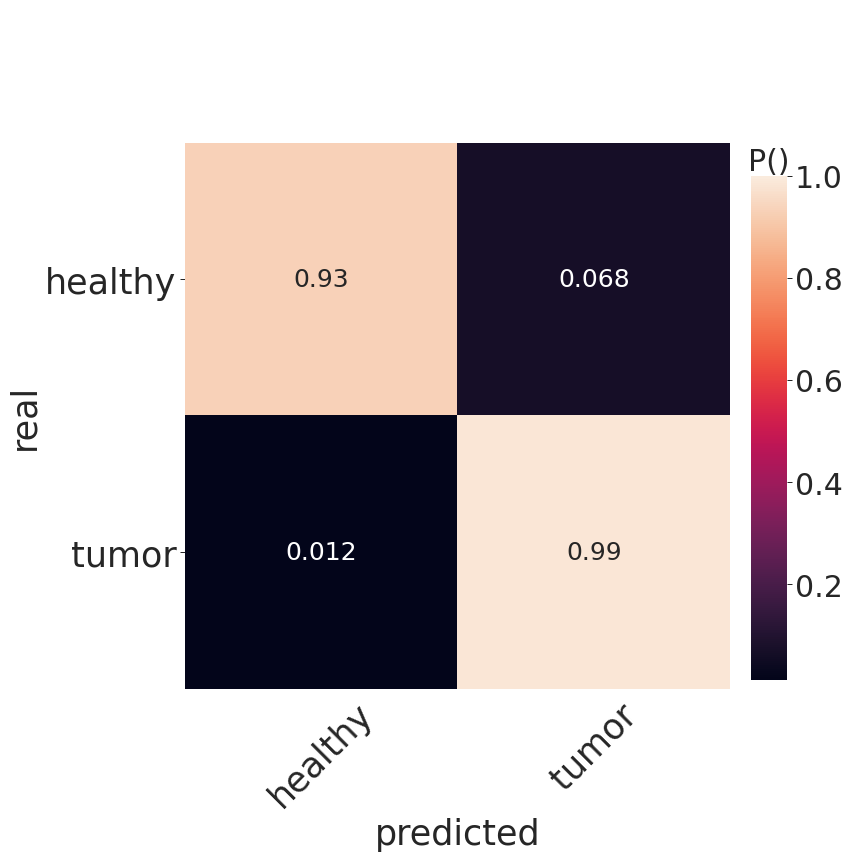

In [1030]:
cm = sns.clustermap(results, 
                    vmax=1,  
                    row_cluster=False, 
                    col_cluster=False, 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    annot=False,
                    annot_kws={"fontsize":25},
                    cbar_pos=(0.99,0.05,0.05,0.7))
ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("real", fontsize=35, rotation=90)
ax.set_yticklabels(labels=classes, rotation=0)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")

ax.set_xticklabels(labels=classes, rotation=45)
ax.set_xlabel("predicted",fontsize=35)
ax.tick_params(labelsize=35)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("P()", fontsize=30)
plt.tight_layout()
cm.savefig(f"predict_{label}.pdf")

plt.show()

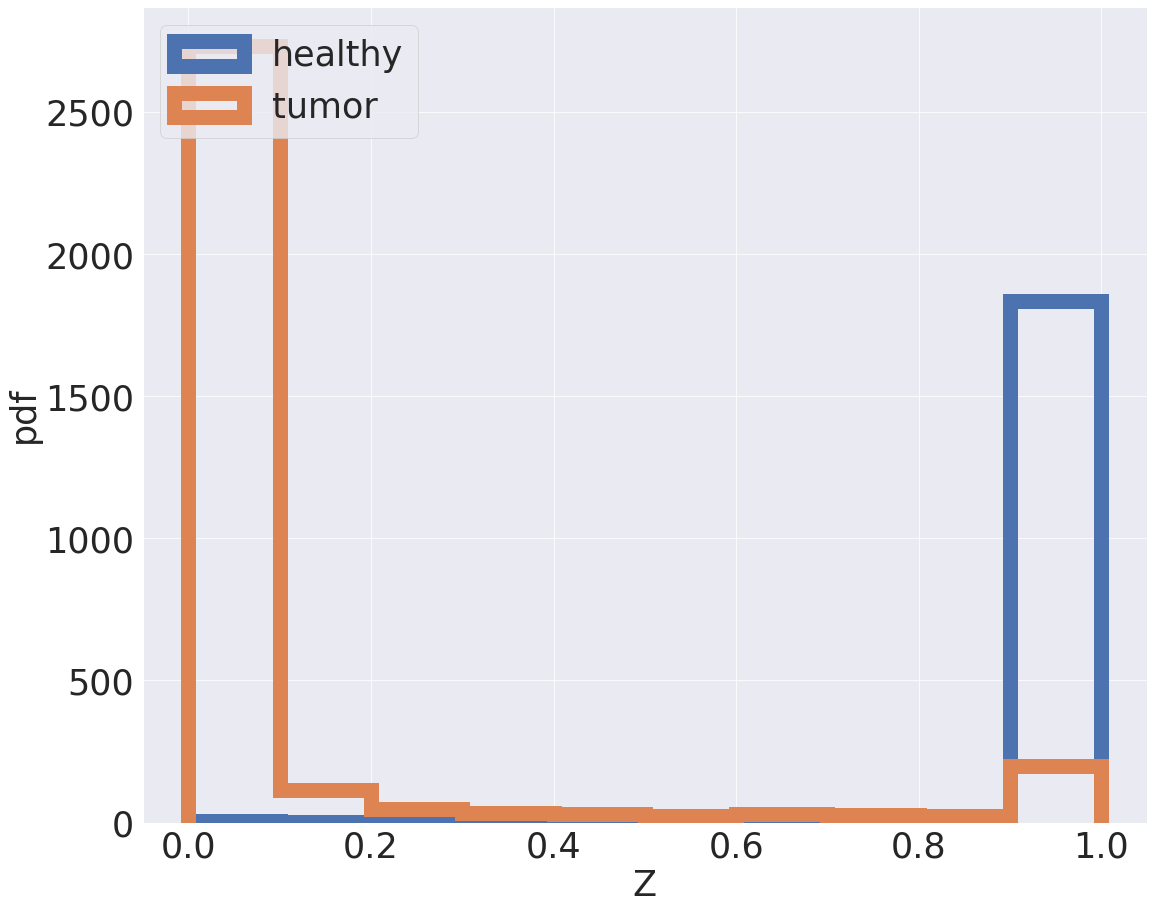

In [1025]:
fig, ax= plt.subplots(figsize=(18,15))

if uniq > 1:
  for c in range(uniq):
    ax.hist((1-model.predict(X_test).T[0])[Y_test.argmax(1)==c], histtype="step", lw=15, bins=10, density=True)
else:
  ax.hist(y_pred_p[Y_test==1], histtype="step", lw=15, bins=10, density=False, label="healthy")
  ax.hist(y_pred_p[Y_test==0], histtype="step", lw=15, bins=10, density=False, label="tumor")

ax.tick_params(labelsize=35)
ax.legend(fontsize=35, loc="upper left")
ax.set_title("", fontsize=35)

ax.set_xlim(-0.05,1.05)

ax.set_xlabel("Z", fontsize=35)
ax.set_ylabel("pdf", fontsize=35)

plt.show()

In [0]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_p.T[0])
#fpr, tpr, thresholds = roc_curve(Y_train, model.predict(X_train))

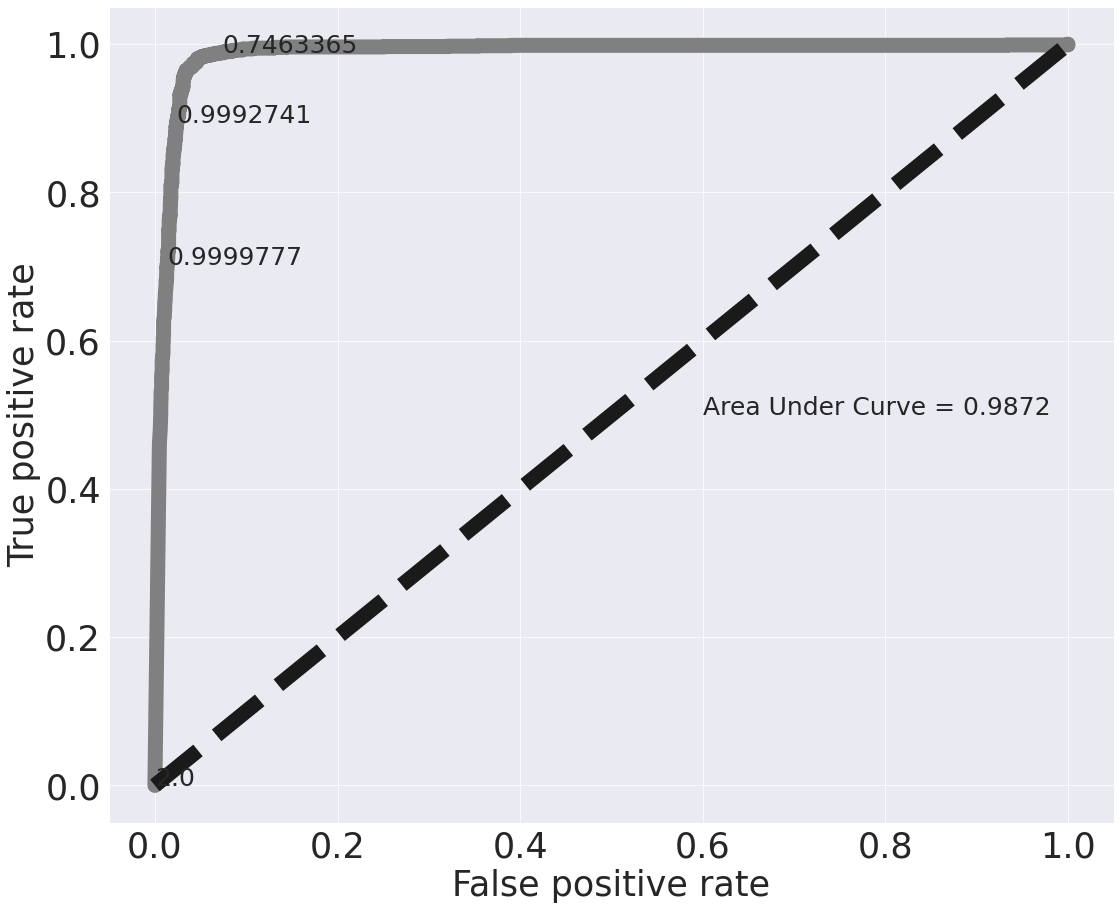

In [1027]:
fig, ax = plt.subplots(figsize=(18,15))

ax.plot(fpr,tpr, c="gray", lw=15)

ax.plot([0, 1], [0, 1], 'k--', lw=15)
ax.set_xlabel('False positive rate', fontsize=35)
ax.set_ylabel('True positive rate', fontsize=35)


for f, t, thr in zip(fpr[::100], tpr[::100], thresholds[::100]):
    ax.annotate(thr, (f, t), fontsize=25)

ax.annotate("Area Under Curve = %.4f"%roc_auc_score(y_true, y_pred_p.T[0]), xy=(0.6, 0.5), fontsize=25)

ax.tick_params(labelsize=35)

plt.show()
fig.savefig(f"roc_{label}.pdf")

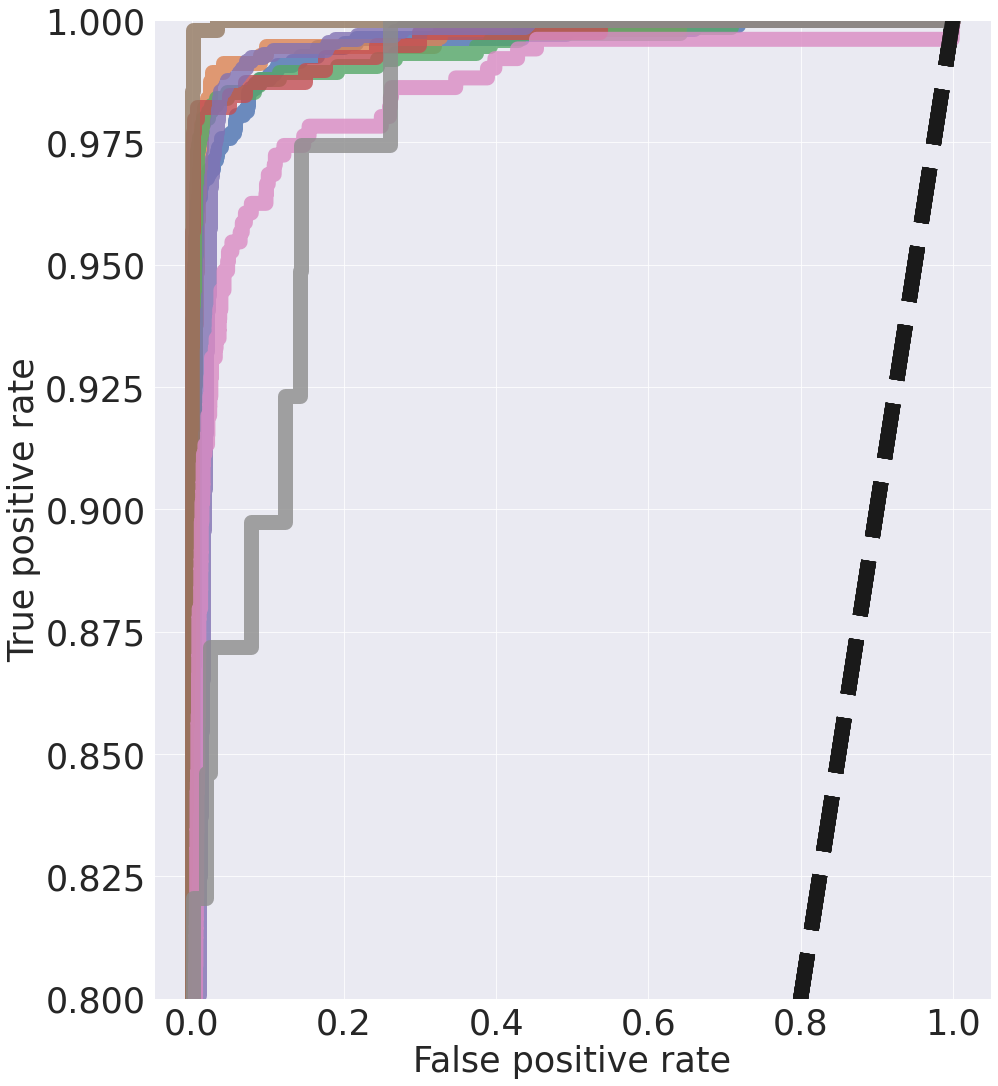

In [1003]:
fig, ax = plt.subplots(figsize=(15,18))
for itissue, tissue in enumerate(classes):
  tissue_true = y_true.copy()
  tissue_true[y_true==itissue]=1
  tissue_true[y_true!=itissue]=0
  fpr, tpr, thresholds = roc_curve(tissue_true, y_pred_p.T[itissue])

  ax.plot(fpr,tpr, lw=15, alpha=0.8)

  ax.plot([0, 1], [0, 1], 'k--', lw=15)
  ax.set_xlabel('False positive rate', fontsize=35)
  ax.set_ylabel('True positive rate', fontsize=35)

  ax.tick_params(labelsize=35)

ax.set_ylim(0.8,1)
plt.show()
fig.savefig(f"roc_{label}.pdf")